# BART BMM: 2D Example
## Author: John Yannotty
### Date: 04/01/23

This example demonstrates the BART-BMM model on a 2-dimensional example. For this example, assume the true system is defined by 

$$f_\dagger(x) = \sin(x_1) + \cos(x_2),$$ 

over the domain $(x_1,x_2) \in [-\pi,\pi]\times [-\pi,\pi]$.  Furthermore, consider a model set which defines $K$ simulators under consideration in terms of Taylor series expanions of $\sin(x_1)$ and $\cos(x_2)$. This example considers mixing two simulators, defined by $h_1(x)$ and $h_2(x)$ as shown below:      

$$h_1(x) = \sum_{j=0}^7 \frac{s^{(j)}(x_1)}{j!}(x_1-\pi)^j + \sum_{k=0}^{10} \frac{c^{(k)}(x_2)}{k!}(x_2-\pi)^k$$
$$h_2(x) = \sum_{j=0}^{13} \frac{s^{(j)}(x_1)}{j!}(x_1+\pi)^j + \sum_{k=0}^6 \frac{c^{(k)}(x_2)}{k!}(x_2+\pi)^k,$$

where $x = (x_1,x_2)$, $s^{(j)}(x_1)$ denotes the jth derivative of $\sin(x_1)$, and $c^{(k)}(x_1)$ denotes the kth derivative of $\cos(x_2)$. The simulator, $h_1(x)$ involves Taylor series expansions of $\sin(x_1)$ and $\cos(x_2)$ about $\pi$. Meanwhile, $h_2(x)$ is constructed using two Taylor series expansions about $-\pi$. 

In [1]:
# Basic imports
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm
from scipy.special import gamma

#! pip install Taweret    # if using Colab, uncomment to install

# Get the current directory and extract the Taweret part
# The current directory should be of the form /..../Taweret/docs/source/notebooks
# where /.../ corresponds to your local directories.
#cwd = os.getcwd()

from pathlib import Path
import sys

cwd = Path().resolve()

for p in [cwd, *cwd.parents]:
    maybe_pkg = p / "src" / "Taweret"
    if maybe_pkg.exists():
        src_dir = (p / "src").resolve()
        sys.path.insert(0, str(src_dir))   # put first so imports find it first
        print("Added to sys.path:", src_dir)
        break
else:
    raise RuntimeError("Couldn't find src/Taweret in any parent directories of cwd")

# now:
import Taweret
print(Taweret.__file__)

# # Get the first part of this path and append to the sys.path
# tw_path = cwd.split("Taweret/")[0] + "Taweret"
# sys.path.append(tw_path)

# Taweret imports
import Taweret.models.polynomial_models 
from Taweret.models.polynomial_models import sin_exp, cos_exp, sin_cos_exp
from Taweret.mix.trees import Trees



Added to sys.path: /Users/alexandra/Desktop/Taweret/src
/Users/alexandra/Desktop/Taweret/src/Taweret/__init__.py


## Training Data

Prior to mixing, we can generate training data over a two-dimensional grid. This is done by first generating a set of training inputs using the `grid_2d_design(...)` function. The function generates points with a space filling design. The 2-dimensional input space is divided into a $n_1 \times n_2$ grid. Then, an input $x = (x_1,x_2)$ is randomly generated in each rectangle of the grid. This results in a total of $n = n_1n_2$ training points. 

The training points are passed through the true function of $f_\dagger(x) = \sin(x_1) + \cos(x_2)$. Then random noise is added to simulate observational data, $Y_1,\ldots,Y_n$. The example below generates data from 80 training points, though one can easily use a smaller or larger training set. 

In [2]:
## Functions for design points 
# n1 = number of bins in the x1 dimension
# n2 = number of bins in the x2 dimension
# n = n1*n2 is the total training size
def grid_2d_design(n1,n2, xmin = [-1,-1], xmax = [1,1]):
  # Generate n uniform rvs
  n = n1*n2
  ux = np.random.uniform(0,1,n)
  uy = np.random.uniform(0,1,n)

  # Dimensions for each rectangle
  x1_len = (xmax[0] - xmin[0])/n1
  x2_len = (xmax[1] - xmin[1])/n2
  xgrid = [[x, y] for x in range(n1) for y in range(n2)]
  xgrid = np.array(xgrid).transpose()

  # Get points
  x1 = ux*x1_len + x1_len*xgrid[0] + xmin[0]
  x2 = uy*x2_len + x2_len*xgrid[1] + xmin[1]

  # Join data
  xdata = np.array([x1,x2]).transpose()
  return xdata

The training inputs is generated over the rectanlge $[-\pi,\pi]^2$. The design points are shown in the figure below. Then, the observational data is independently generated according to 

$$Y_i \sim  N(f_\dagger(x_i),\sigma^2),$$

where $x_i = (x_{i1},x_{i2})$ is the ith training input for $i=1,\ldots,n$. In this example, $n = 80$.

In [3]:
# Generate Data
nx1 = 10; nx2 = 8
n_train = nx1*nx2
x_train = grid_2d_design(nx1,nx2,[-np.pi,-np.pi],[np.pi,np.pi])
f0_train = np.sin(x_train.transpose()[0]) + np.cos(x_train.transpose()[1])
y_train = f0_train + np.random.normal(0,0.1,n_train)


The design of the experiment is shown below. Clearly the training points are spread out across the entire domain.

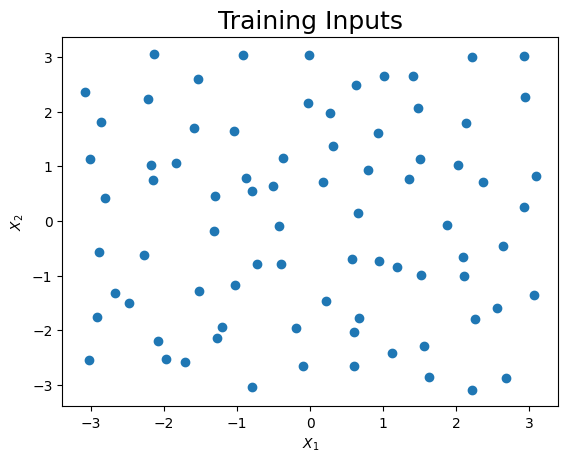

In [4]:
# Visualize the 
plt.scatter(x_train.transpose()[0],x_train.transpose()[1])
plt.title("Training Inputs", size = 18)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.show()


### The Model Set

Now we can visualize the three expansions under consideration. Each surface is shown below. Note, the plots are truncated in areas where the expansion diverges. This is done only for visual purposes.

The first plot illustrates the true surface. This surface has various peaks and valleys across the input domain. We will see each simulator can be used to explain one of these features of the true surface. The plot is generated by evaluating $f_\dagger(x)$ over a dense grid of points across the input domain.

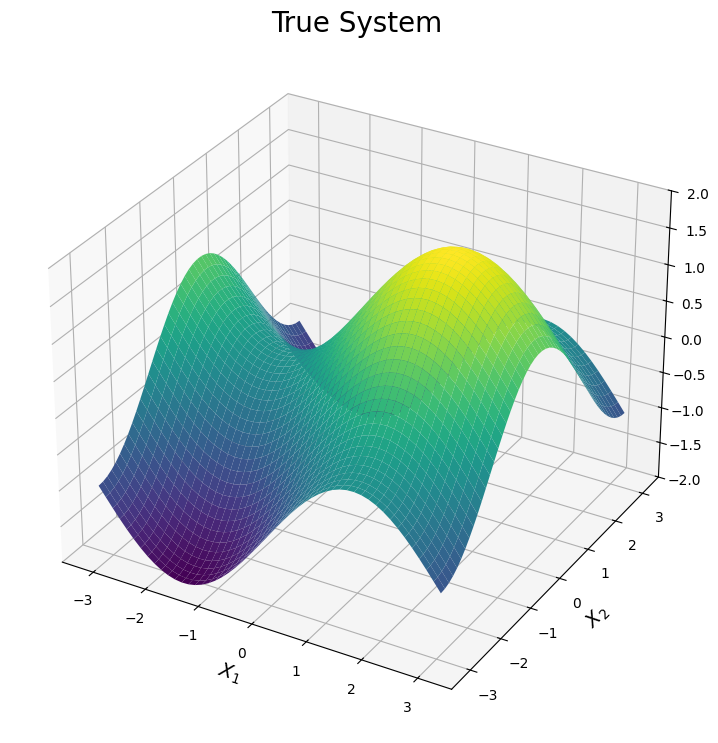

In [5]:
# Plot the surfaces
n_test = 50
x1_test = np.outer(np.linspace(-np.pi, np.pi, n_test), np.ones(n_test))
x2_test = x1_test.copy().transpose()
f0_test = (np.sin(x1_test) + np.cos(x2_test))
x_test = np.array([x1_test.reshape(x1_test.size,),x2_test.reshape(x1_test.size,)]).transpose()

# Define color map
cmap = plt.get_cmap('viridis')

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
plt.title("True System", size = 20)
plt.xlabel(r"$X_1$", size = 14)
plt.ylabel(r"$X_2$", size = 14)
ax.set_zlim([-2,2])

# show plot
plt.show()

Now we can view the two simulators we wish to mix. The first simulator is comprised of two Taylor series expansions centeres about $\pi$, hence it provides higher fidelity predictions in the upper right corner of the domain. The second simulator is comprised of two Taylor series expansions centeres about $-\pi$. Additionally, its Taylor series expansion of $\sin(x)$ is a high-fidelity approximation across the entire interval of $[\pi,\pi]$. Hence $h_2(x)$ provides higher fidelity predictions in the bottom half of the domain. 

The surfaces produced by each simulator are shown below.

#### The $h_1(x)$ surface

The first expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(\pi,\pi)$. Based on the plot below, we can see the first expansion is designed to approximate the peak of the true system in this upper right corner of the domain. Meanwhile, the prediction diverges as $x_1$ or $x_2$ moves away from $\pi$. Note for visual purposes, the plot below truncates the approximation in these diverging regions. 

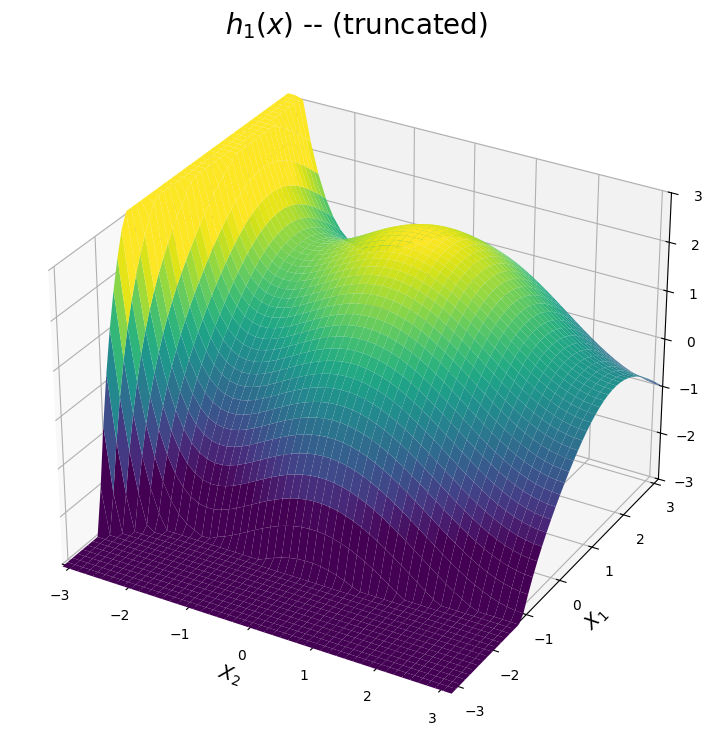

In [6]:
# Plot the first simulator
sin7 = sin_exp(7,np.pi)
cos10 = cos_exp(10,np.pi)

h1_sin = sin7.evaluate(x1_test.transpose()[0])[0]
h1_cos = cos10.evaluate(x1_test.transpose()[0])[0]

h1_sin_grid = np.outer(h1_sin, np.ones(n_test))
h1_cos_grid = np.outer(h1_cos, np.ones(n_test)).transpose()

h1_test = h1_sin_grid + h1_cos_grid

# Subset the data for the plot (only for visualization)
h1_test_filter = h1_test.copy()
for i in range(n_test):
    h1_test_filter[i][np.where(h1_test_filter[i]>3)] = 3.05
    h1_test_filter[i][np.where(h1_test_filter[i]<-3)] = -3.05
    
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x2_test, x1_test, h1_test_filter, cmap = cmap, vmin = -2, vmax = 2)
ax.set_zlim([-3,3])
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-np.pi,np.pi])
plt.title(r"$h_1(x)$ -- (truncated)", size = 20)
plt.xlabel(r"$X_2$", size = 14)
plt.ylabel(r"$X_1$", size = 14)

# show plot
plt.show()

#### The $h_2(x)$ surface

The second expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(-\pi,-\pi)$. Additionally, the expansion of $\sin(x_1)$ is a high-fidelity apprixmation of $\sin(x_1)$ across the interval $[-\pi,\pi]$. Hence, from the plot below, $h_2(x)$ can be used to approximate the valley and curvature in the true function for points in the bottom region of the domain. Once again, the surface is truncated for visual purposes in regions where the expansion diverges. 

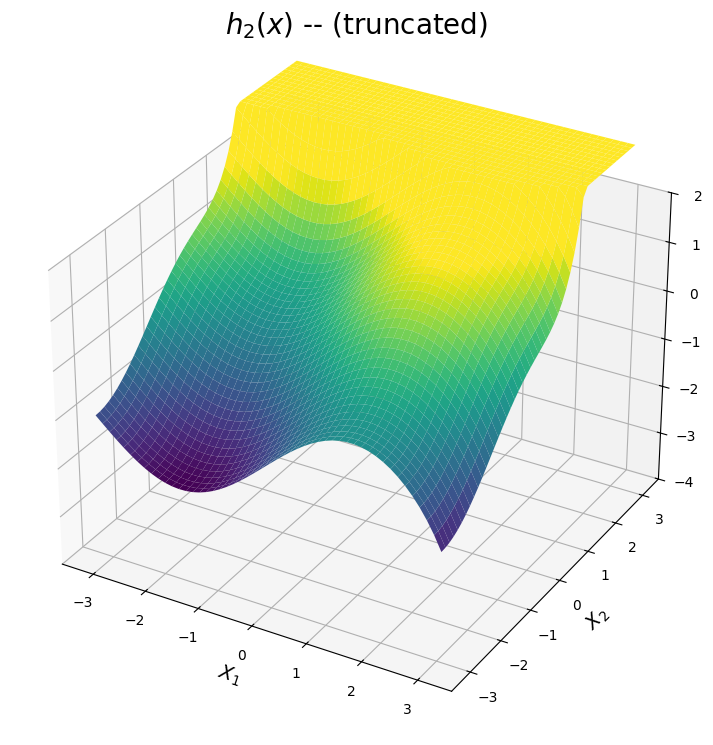

In [7]:
# Plot the second simulator
sin13 = sin_exp(13,-np.pi)
cos6 = cos_exp(6,-np.pi)

h2_sin = sin13.evaluate(x1_test.transpose()[0])[0]
h2_cos = cos6.evaluate(x1_test.transpose()[0])[0]

h2_sin_grid = np.outer(h2_sin, np.ones(n_test))
h2_cos_grid = np.outer(h2_cos, np.ones(n_test)).transpose()

h2_test = h2_sin_grid + h2_cos_grid

# Subset the data for the plot (only for visualization)
h2_test_filter = h2_test.copy()
for i in range(n_test):
    h2_test_filter[i][np.where(h2_test_filter[i]>3)] = 3.05
    h2_test_filter[i][np.where(h2_test_filter[i]<-3)] = -3.05


# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.set_zlim([-4,2])
ax.plot_surface(x1_test, x2_test, h2_test_filter,cmap = cmap, vmin = -2, vmax = 2)
plt.title(r"$h_2(x)$ -- (truncated)", size = 20)
plt.xlabel(r"$X_1$", size = 14)
plt.ylabel(r"$X_2$", size = 14)

# show plot
plt.show()

Alternatively, we can view the accuracy of each individual Taylor Series expansions. The top two expansions are added together to obtain the first simulator, while the second two expansions are added together to obtain the second simulator. The following observations are made:

* The top two plots suggest the first simulator $h_1(x)$, is an accurate approximation of the true function for positive $x_1$ and $x_2$.

* The bottom two plots suggest the second simulator $h_2(x)$, is an accurate approximation of the true function for negative $x_2$ and any $x_1$.

Hence, we expect $h_1(x)$ to be influential in the upper right corner of the domain and $h_2(x)$ to be influential in the bottom half of the domain. These results should be reflected in the final posterior weights for the mixed model. 

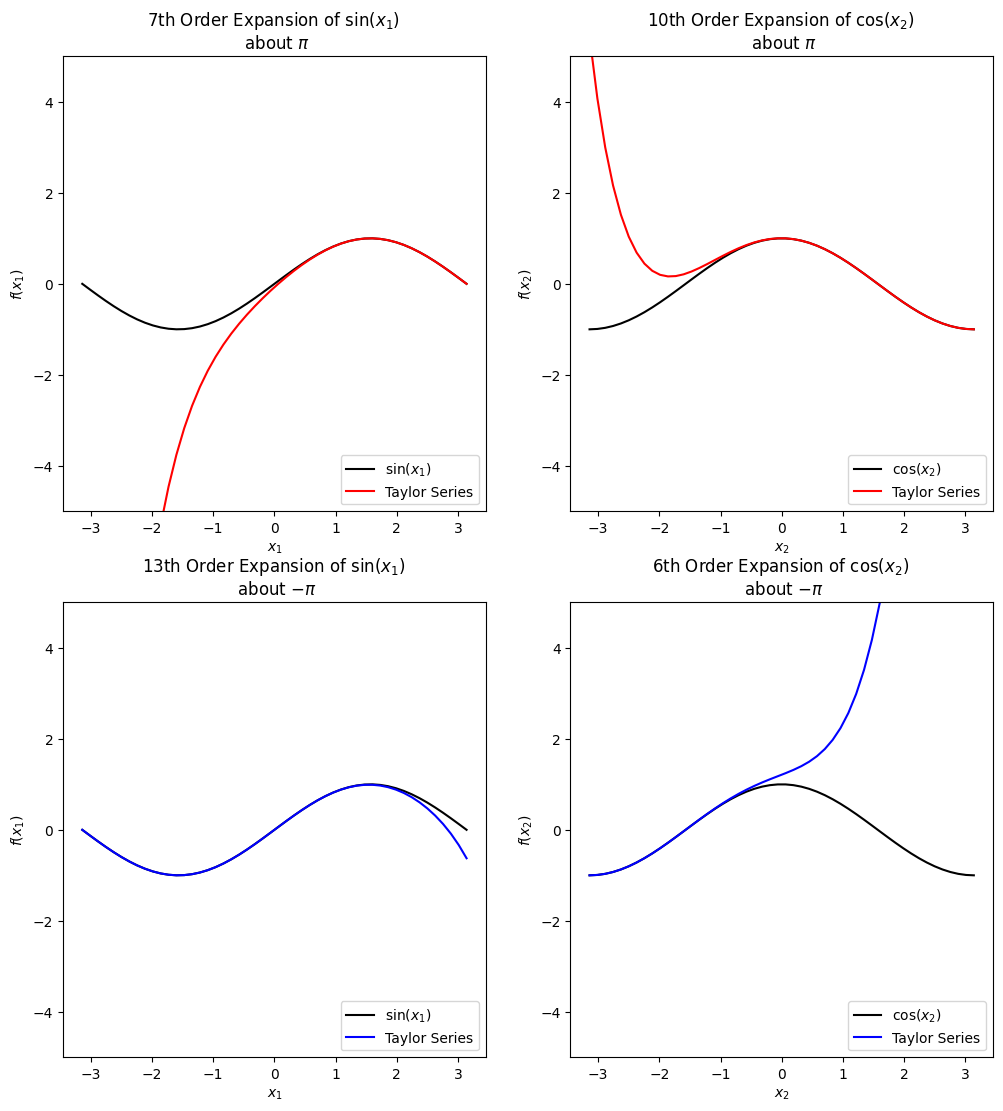

In [20]:
# Plot the marginal effects of each expansion
exp_list = [h1_sin, h1_cos, h2_sin, h2_cos]
exp_title = [r"7th Order Expansion of $\sin(x_1)$ \n about $\pi$",r"10th Order Expansion of $\cos(x_2)$ \n about $\pi$",\
             r"13th Order Expansion of $\sin(x_1)$ \n about $-\pi$ ", r"6th Order Expansion of $\cos(x_2)$ \n about $-\pi$"]

k = 0
fig, ax = plt.subplots(2,2,figsize = (12,13))
for i in range(2):
    if i == 0:
        exp_color = 'red'
    else:
        exp_color = 'blue'
    for j in range(2):
        if j == 0:
            ax[i][j].plot(x1_test.transpose()[0], np.sin(x1_test.transpose()[0]), color = 'black')
            exp_label = r"$\sin(x_1)$"
        else:
            ax[i][j].plot(x1_test.transpose()[0], np.cos(x1_test.transpose()[0]), color = 'black')
            exp_label = r"$\cos(x_2)$"

        ax[i][j].plot(x1_test.transpose()[0], exp_list[k], color = exp_color)
        ax[i][j].set_ylim(-5,5)
        ax[i][j].set_ylabel(r"$f(x_"+str(j+1)+ ")$")
        ax[i][j].set_xlabel(r"$x_"+str(j+1)+"$")
        ax[i][j].set_title(exp_title[k])
        ax[i][j].legend([exp_label, "Taylor Series"],loc = "lower right")
        # Increment total plot index
        k = k + 1



## The BART BMM Model

This section demonstrates how to train the BMM model for the 2D example. Note, it is assumed the software has been installed prior to running this notebook. 

**If the software has not yet been installed, please follow the instructions listed in the Installaion section of the Taweret Documentation page.** 

The BART-BMM model is trained using the following steps. 

1. Define the model set using the three lines of code shown below. The first two lines defines a class instance for each Taylor series expansion. The third line of code defines the model set.  

In [9]:
# Define the model set
h1 = sin_cos_exp(7,10,np.pi,np.pi)
h2 = sin_cos_exp(13,6,-np.pi,-np.pi)
model_dict = {'model1':h1, 'model2':h2}

2. Define the class instance of the BART-BMM using the `Trees` class. For this example, the class instance is called `mix`.

3. Set the prior information using the `set_prior()` method. A discussion of the hyperparameters and tuning parameters used in `set_prior()` can be found in the next subsection.

4. Fit the model using the `train()`. This requires the user to pass in the data and relevant MCMC arguments.  

In [10]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict)

# Set prior information
mix.set_prior(k=2.5,ntree=30,nu=5,sighat=0.01,inform_prior=False)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 10000, nadapt = 2000, nskip = 2000, adaptevery = 500, minnumbot = 4)


Running model...


5. Obtain the predictions from the mixed function and the corresponding weight functions using the methods `predict()` and `predict_weights()`, respectively. Both methods require an array of test points and a confidence level.

In [11]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


### Setting Prior Distibutions

Two of the priors in the BART model are described below. The descriptions are followed by plots of the prior densities at various settings of the hyperparameters. 

#### The weight function prior

Each of the $K$ weight functions are regularized via a Gaussian prior. Assuming an ensemble of $m$ trees are used to learn the weight functions, the prior for each weight is defined by 

$$w_l(x) \mid \mathcal{T} \sim N(0.5, m\tau^2), \quad l = 1,\ldots,K,$$

where $K$ is the number of models under consideration and $\mathcal{T} = T_1,\ldots,T_m$ is the set of trees. Meanwhile, $\tau$ is specified as 

$$\tau = \frac{1}{2k\sqrt{m}},$$

where $k$ is a tuning parameter. Increasing $k$ limits the flexibility of each weight and concentrates the prior of each weight around the central point of 0.5.  

#### The error variance prior

The error variance is assigned a scaled inverse chi-square distribution, dentoed by $\;\sigma^2 \sim \lambda\nu/\chi^2_\nu$. The hyperparameters of $\nu$ and $\lambda$ control the shape and scale of the prior respectively. Increasing $\nu$ will result in a prior with a higher peak, while increasing $\lambda$ will shift the prior to the right.


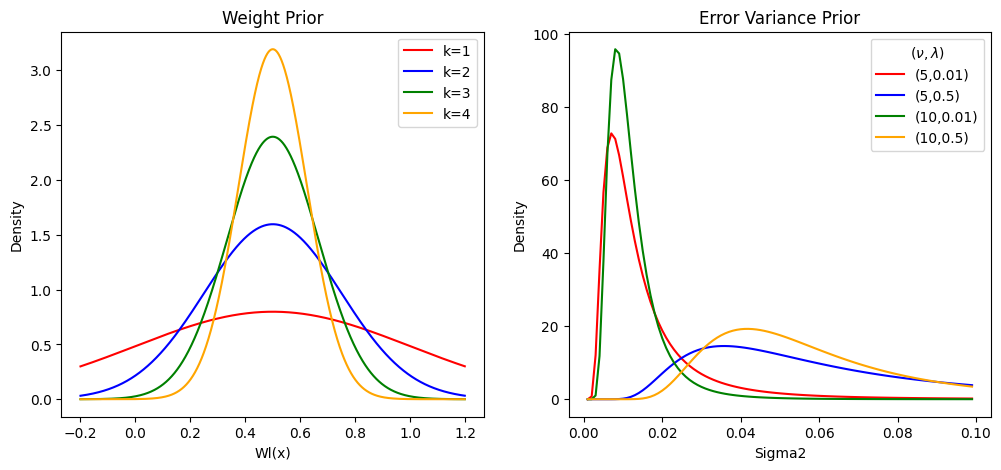

In [19]:
# Define different values for m*tau^2
mtau2_vec = 0.25*np.array([1,1/4,1/9,1/16])

# Evaluate the weight prior density of a grid of points
w_grid = np.arange(-0.2,1.2,0.001)
wprior1 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[0]))
wprior2 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[1]))
wprior3 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[2]))
wprior4 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[3]))

# Now evaluate the variance prior
def scaled_inv_chi2(sig2, nu, lam):
    den = (lam*nu/2)**(nu/2)/(gamma(nu/2)*sig2**(1+nu/2))*np.exp(-nu*lam/(2*sig2))
    return den

s_grid = np.arange(0.001,0.1,0.001)
sprior1 = scaled_inv_chi2(s_grid, 5, 0.01)
sprior2 = scaled_inv_chi2(s_grid, 5, 0.05)
sprior3 = scaled_inv_chi2(s_grid, 10, 0.01)
sprior4 = scaled_inv_chi2(s_grid, 10, 0.05)


# Plot the prior
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(w_grid, wprior1, color = 'red')
ax[0].plot(w_grid, wprior2, color = 'blue')
ax[0].plot(w_grid, wprior3, color = 'green')
ax[0].plot(w_grid, wprior4, color = 'orange')
ax[0].set_title("Weight Prior")
ax[0].set_xlabel("Wl(x)")
ax[0].set_ylabel("Density")
ax[0].legend(["k=1","k=2","k=3","k=4"], loc = "upper right")

# Plot the prior
ax[1].plot(s_grid, sprior1, color = 'red')
ax[1].plot(s_grid, sprior2, color = 'blue')
ax[1].plot(s_grid, sprior3, color = 'green')
ax[1].plot(s_grid, sprior4, color = 'orange')
ax[1].set_title("Error Variance Prior")
ax[1].set_xlabel("Sigma2")
ax[1].set_ylabel("Density")
ax[1].legend(["(5,0.01)","(5,0.5)","(10,0.01)","(10,0.5)"], loc = "upper right", title = r"$(\\nu, \\lambda)$")




### Predictions 

The resulting predicted system is shown below. The prediction is very accurate across the domain and is able to recover the peaks and valleys of the true function. The prediction struggles along the edges when one or both simulators diverge. For instance, a poor prediction is seen in the top left corner of the domain where both simulators are inaccurate and minimal training data is present. 

(-2.5, 2.5)

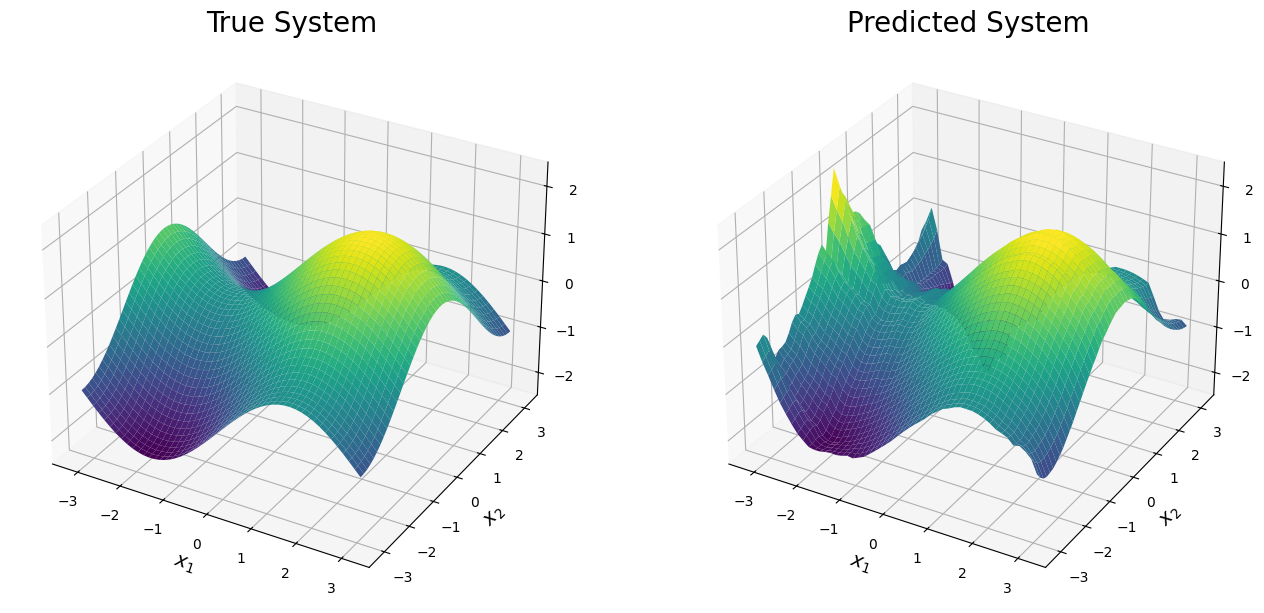

In [13]:
# Create Figure
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
ax.set_title("True System", size = 20)
ax.set_xlabel(r"$x_1$", size = 14)
ax.set_ylabel(r"$x_2$", size = 14)
ax.set_zlim([-2.5,2.5])

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x1_test, x2_test, pmean.reshape(x1_test.shape), cmap = cmap, vmin = -2, vmax = 2)
ax.set_title("Predicted System", size = 20)
ax.set_xlabel(r"$x_1$", size = 14)
ax.set_ylabel(r"$x_2$", size = 14)
ax.set_zlim([-2.5,2.5])


In [14]:
# Get the training error
np.sqrt(np.mean((pmean - f0_test.reshape(pmean.shape))**2))

np.float64(0.18770569648721214)

Another way to visually compare the posterior mean prediction and the true system is by a heat map, as shown below. From this, we can see the posterior mean prediction accurately predicts the true system across the majority of the domain. Additionally, the prediction idenitifies the main feautres of the true system that align with the expansions under consideration. Specifically, the BART-based prediction adequately identifies the peak of the system (yellow) and the two saddle points (dark blue). The saddle point in the bottom left corner of the domain is accurately recovered due to the information in the 2nd expansion and the observational data. Meanwhile, the prediction of saddle point in the upper left corner has some noticeable error because neither expansion is accurate in this region and only a few data points are present. 

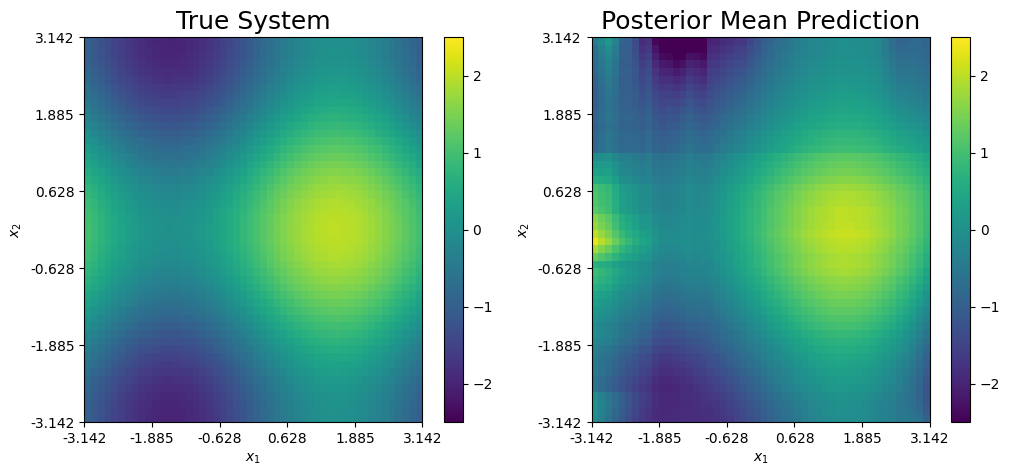

In [15]:
# Heat map comparing the surfaces
fig, ax = plt.subplots(1,2, figsize = (12,5))

pcm1 = ax[0].pcolormesh(f0_test.transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[0].set_title("True System", size = 18)
ax[0].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm1,ax = ax[0])


# Predicted mean
pcm2 = ax[1].pcolormesh(pmean.reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[1].set_title("Posterior Mean Prediction", size = 18)
ax[1].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm2,ax = ax[1])

Next, we can view the upper and lower bounds from the corresponding 95% credible interval of the prediction. Bassed on the plots below, it appears minimal uncertainty exists across the areas where at least one expansion is accurate. The uncertainty is quite large in the upper left corner due to the sparce data in this region and the diverging expansions.  

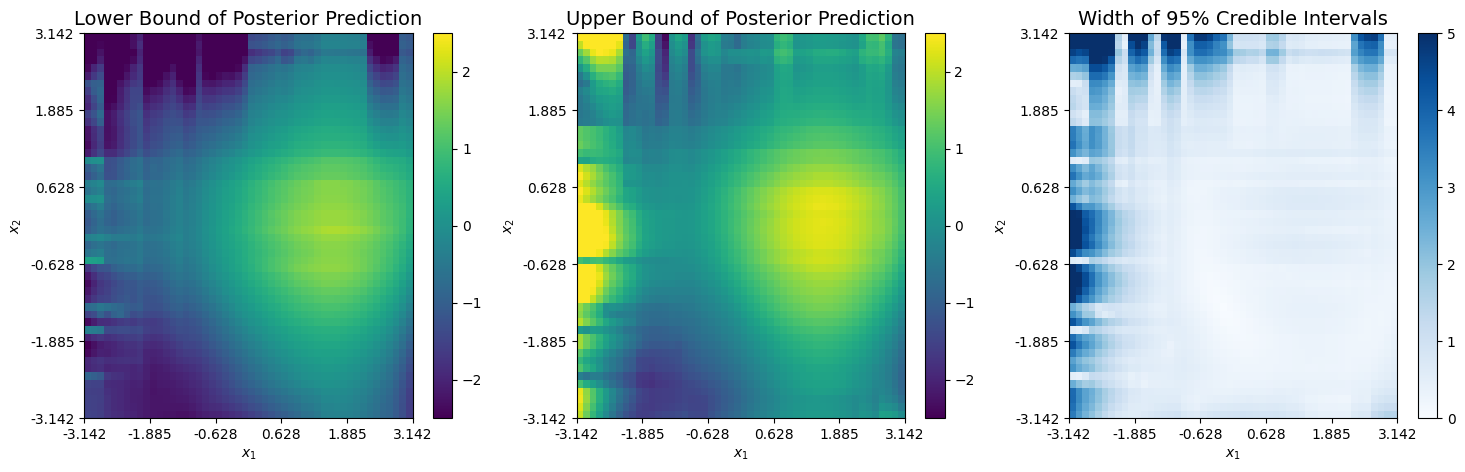

In [16]:
# Lower bound
cmap_blues = plt.get_cmap("Blues")
fig, ax = plt.subplots(1,3, figsize = (18,5))

pcm0 = ax[0].pcolormesh(pci[0].reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[0].set_title("Lower Bound of Posterior Prediction", size = 14)
ax[0].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm0,ax = ax[0])


# Upper bound
pcm1 = ax[1].pcolormesh(pci[1].reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[1].set_title("Upper Bound of Posterior Prediction", size = 14)
ax[1].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm1,ax = ax[1])


# CI Width
pcm2 = ax[2].pcolormesh((pci[1].reshape(x1_test.shape) - pci[0].reshape(x1_test.shape)).transpose(),cmap = cmap_blues, vmin = 0, vmax = 5)
ax[2].set_title("Width of 95% Credible Intervals", size = 14)
ax[2].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[2].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[2].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[2].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[2].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm2,ax = ax[2])


Finally, we can plot the mean residual, which is defined as $\hat{r}(x) = f_\dagger(x) - \hat{f}_\dagger(x)$. Clearly, the majority of the prediction error is atrributed to the upper left corner, wehere both expansions diverge.   

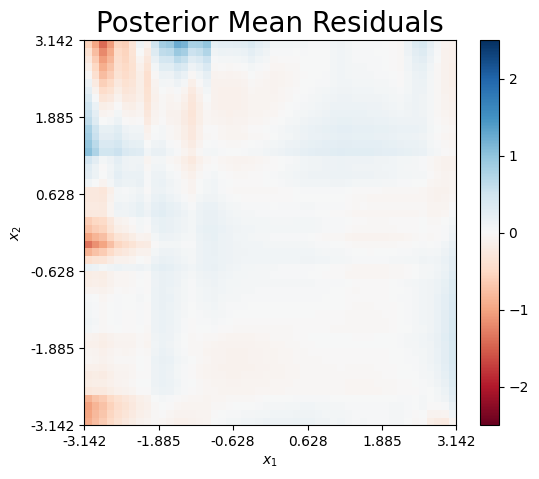

In [17]:
# Residual Plots
cmap_rb = plt.get_cmap("RdBu")
fig, ax = plt.subplots(1,1, figsize = (6,5))

pcm1 = ax.pcolormesh((f0_test - pmean.reshape(x1_test.shape)).transpose(),cmap = cmap_rb, vmin = -2.5, vmax = 2.5)
ax.set_title("Posterior Mean Residuals", size = 20)
ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax.xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm1,ax = ax)


### Weight Functions

The mean weight functions for both simulators are shown below. Both weight functions take higher values when the corresponding simulator provides a higher-fidelity approximation. Note, the patterns in the weight functions match the intuition about where each simulator is locally accurate or inaccurate as previously described. 

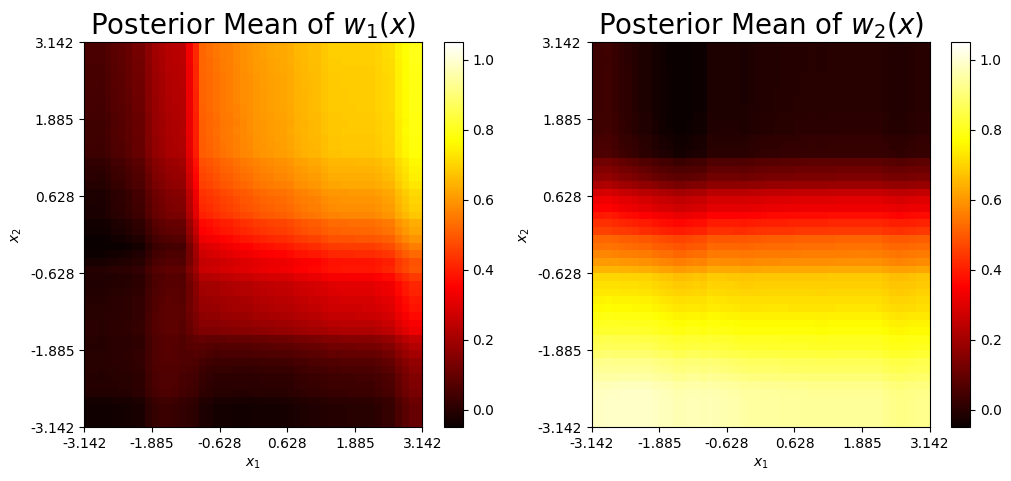

In [18]:
cmap_hot = plt.get_cmap('hot')
w1 = wmean.transpose()[0]
w2 = wmean.transpose()[1]

w1_mean = wmean.transpose()[0]
w1_mean = w1_mean.reshape(x1_test.shape).transpose()

w2_mean = wmean.transpose()[1]
w2_mean
w2_mean = w2_mean.reshape(x1_test.shape).transpose()

fig, ax = plt.subplots(1,2, figsize = (12,5))
pcm0 = ax[0].pcolormesh(w1_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
ax[0].set_title(r"Posterior Mean of $w_1(x)$", size = 20)
ax[0].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm0,ax = ax[0])

pcm1 = ax[1].pcolormesh(w2_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
ax[1].set_title(r"Posterior Mean of $w_2(x)$", size = 20)
ax[1].set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm1,ax = ax[1])


### Error Standard Deviation
Finally, the posterior of the error standard deviation concentrates about the true value of 0.1. This means, the error standard deviation is accurately recovered with small uncertainty. 

## Conclusions

* The BART-BMM model can combine two expansions uisng observational data to obtain improved global prediction and interpretation.

* The mixed-prediction is accurate across the entire domain outisde of the upper left corner, where both expansions diverge.

* The weight functions are adaptively learned by an ensemble of trees.

* A weight function takes values closer to 1 in areas where the corresponding expansion is accurate. Meanwhile, it takes values near 0 when the expansion is innaccurate.

* The true error standard deviation of 0.10 is accurately recovered.

